[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/csikosmarci24/vitmav45-Mayuyu/blob/main/project/data_visualization.ipynb)

# Libraries

In [2]:
import torch

!pip install pyvis

# https://stackoverflow.com/questions/67285115/building-wheels-for-torch-sparse-in-colab-takes-forever
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-v80gyaop
  Running command git clone -q https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-v80gyaop
  Created wheel for torch-geomet

In [32]:
import gzip
import zipfile
import pandas as pd
import networkx as nx
from pyvis import network as net
from IPython.core.display import display, HTML
from torch_geometric.utils.convert import from_networkx
import xml.etree.ElementTree as ET
import collections

# Download from Google Drive

In [6]:
# graph
!gdown 1Ot-ICpiJRlisFvM9Fi6TM3Q6kAZaLS0y
# DrugBank
!gdown 1LSdAthCa69kWRIKoI5UmclLgf4OsSNAm
# xsd
!gdown 15_hqow9NT_M49OX7cXrG5P6vCgfbKyhP

Downloading...
From: https://drive.google.com/uc?id=1Ot-ICpiJRlisFvM9Fi6TM3Q6kAZaLS0y
To: /content/ChCh-Miner_durgbank-chem-chem.tsv.gz
100% 207k/207k [00:00<00:00, 60.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LSdAthCa69kWRIKoI5UmclLgf4OsSNAm
To: /content/drugbank_all_full_database.xml.zip
100% 152M/152M [00:01<00:00, 84.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=15_hqow9NT_M49OX7cXrG5P6vCgfbKyhP
To: /content/drugbank.xsd
100% 43.2k/43.2k [00:00<00:00, 48.4MB/s]


# Process DrugBank database
(based on https://github.com/dhimmel/drugbank/blob/gh-pages/parse.ipynb)

In [30]:
with zipfile.ZipFile('drugbank_all_full_database.xml.zip', 'r').open('full database.xml') as xml_file:
    tree = ET.parse(xml_file)
root = tree.getroot()

In [33]:
ns = '{http://www.drugbank.ca}'
inchikey_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChIKey']/{ns}value"
inchi_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChI']/{ns}value"

rows = list()
for i, drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['description'] = drug.findtext(ns + "description")
    row['groups'] = [group.text for group in
        drug.findall("{ns}groups/{ns}group".format(ns = ns))]
    row['atc_codes'] = [code.get('code') for code in
        drug.findall("{ns}atc-codes/{ns}atc-code".format(ns = ns))]
    row['categories'] = [x.findtext(ns + 'category') for x in
        drug.findall("{ns}categories/{ns}category".format(ns = ns))]
    row['inchi'] = drug.findtext(inchi_template.format(ns = ns))
    row['inchikey'] = drug.findtext(inchikey_template.format(ns = ns))
    
    # Add drug aliases
    aliases = {
        elem.text for elem in 
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}synonyms/{ns}synonym[@language='English']".format(ns = ns)) +
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}products/{ns}product/{ns}name".format(ns = ns))

    }
    aliases.add(row['name'])
    row['aliases'] = sorted(aliases)

    rows.append(row)

In [34]:
def collapse_list_values(row):
    for key, value in row.items():
        if isinstance(value, list):
            row[key] = '|'.join(value)
    return row

rows = list(map(collapse_list_values, rows))

In [37]:
columns = ['drugbank_id', 'name', 'type', 'groups', 'atc_codes', 'categories', 'inchikey', 'inchi', 'description']
drugbank_df = pd.DataFrame.from_dict(rows)[columns]
drugbank_df

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi,description
0,DB00001,Lepirudin,biotech,approved,B01AE02,"Amino Acids, Peptides, and Proteins|Anticoagul...",None,None,Lepirudin is identical to natural hirudin exce...
1,DB00002,Cetuximab,biotech,approved,L01XC06,"Amino Acids, Peptides, and Proteins|Antibodies...",None,None,Cetuximab is a recombinant chimeric human/mous...
2,DB00003,Dornase alfa,biotech,approved,R05CB13,"Amino Acids, Peptides, and Proteins|Cough and ...",None,None,Dornase alfa is a biosynthetic form of human d...
3,DB00004,Denileukin diftitox,biotech,approved|investigational,L01XX29,"ADP Ribose Transferases|Amino Acids, Peptides,...",None,None,A recombinant DNA-derived cytotoxic protein co...
4,DB00005,Etanercept,biotech,approved|investigational,L04AB01,"Agents reducing cytokine levels|Amino Acids, P...",None,None,Dimeric fusion protein consisting of the extra...
...,...,...,...,...,...,...,...,...,...
14589,DB16742,RP-67580,small molecule,experimental,,"Heterocyclic Compounds, Fused-Ring|Neurokinin-...",None,None,
14590,DB16743,Nolpitantium chloride,small molecule,experimental,,,None,None,
14591,DB16744,CP-96345,small molecule,experimental,,"Analgesics|Analgesics, Non-Narcotic|Anti-Infla...",None,None,
14592,DB16745,PXT 3003,small molecule,investigational,,,WRUIDZKNUAHKTR-UHFFFAOYSA-N,InChI=1S/C21H27N3O2/c1-2-26-21(25)17-13-19(22-...,PXT 3003 is in phase 3 clinical trials for the...


# Visualize graph

In [10]:
with gzip.open('ChCh-Miner_durgbank-chem-chem.tsv.gz') as f:
    graph_df = pd.read_csv(f, delimiter='\t', names=['Source', 'Target'])

In [15]:
graph_df

,Source,Target
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


In [12]:
# Networkx graph
nx_graph = nx.from_pandas_edgelist(graph_df, source='Source', target='Target')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


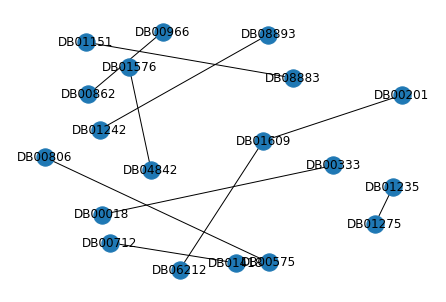

In [ ]:
# Visualize first 10 edges
graph_part = nx.from_pandas_edgelist(graph_df[0:10], source='Source', target='Target')
g = net.Network(notebook=True)
g.from_nx(graph_part)
nx.draw(graph_part, nx.spring_layout(graph_part, k=0.75, iterations=20), with_labels=True)

In [ ]:
g.show('nx.html')
display(HTML('nx.html'))

# Transform graph to PyTorch Geometric

In [13]:
pyt_graph = from_networkx(nx_graph)

In [14]:
pyt_graph

Data(edge_index=[2, 97028], num_nodes=1514)